In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [3]:
#import data
df = pd.read_csv('/home/kolade/repos/house-prediction/dataset/house_prices_data.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_copy = df.copy()

In [5]:
#split data
train_X, test_X, train_y, test_y = train_test_split(df, df.SalePrice, test_size=0.15, random_state =42,shuffle = True)

In [6]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((1241, 81), (219, 81), (1241,), (219,))

In [2]:
#import selected features
selected_features_series =  pd.read_csv('/home/kolade/repos/house-prediction/dataset/selected_features.csv', header=None)[0]
list_selected_feats=list(selected_features_series.values)
list_selected_feats.append('LotFrontage')

In [3]:
list_selected_feats

['OverallQual',
 'GarageCars',
 'hasFireplaces',
 'ExterQual',
 'BsmtQual',
 'GrLivArea',
 'Neighborhood',
 'FullBath',
 'KitchenQual',
 'KitchenAbvGr',
 '2ndFlrSF',
 'PoolArea',
 '1stFlrSF',
 'GarageCond',
 'TotRmsAbvGrd',
 'GarageQual',
 'BsmtFinSF1',
 'TotalBsmtSF',
 'GarageFinish',
 'CentralAir',
 'FireplaceQu',
 'LandContour',
 'LotFrontage']

In [8]:
# missing values for categorical features, accounting for the generated feature hasFireplaces
missing_cat_vars = [i for i in list_selected_feats if i != 'hasFireplaces' and train_X[i].isnull().sum()>1 and train_X[i].dtypes=='O']

In [9]:
missing_cat_vars

['BsmtQual', 'GarageCond', 'GarageQual', 'GarageFinish', 'FireplaceQu']

In [10]:
def fill_categorical_na(data, cat_missing_cols):
    """ Creates another category in categorical features by filling missing values with 'MissingValue' """
    df_copy = data.copy()
    df_copy[cat_missing_cols] = data[cat_missing_cols].fillna("MissingValue") 
    return df_copy

In [11]:
#fill categorical variables
train_X = fill_categorical_na(train_X,missing_cat_vars)
test_X = fill_categorical_na(test_X,missing_cat_vars)

In [12]:
#verify
display(train_X[missing_cat_vars].isnull().sum())
print("----Test")
display(test_X[missing_cat_vars].isnull().sum())

BsmtQual        0
GarageCond      0
GarageQual      0
GarageFinish    0
FireplaceQu     0
dtype: int64

----Test


BsmtQual        0
GarageCond      0
GarageQual      0
GarageFinish    0
FireplaceQu     0
dtype: int64

In [13]:
# get missing numerical variable takinh account of generated feature hasFireplaces
missing_num_vars = [i for i in list_selected_feats if i != 'hasFireplaces' and train_X[i].isnull().sum()>1 and train_X[i].dtypes!='O']

In [14]:
#fill numeric missing value with median 
missing_feats_median = {}
for i in missing_num_vars:
        median = train_X[i].median()
        missing_feats_median[i] = median

        train_X[i]= train_X[i].fillna(median)
        
        test_X[i]= test_X[i].fillna(median)

In [15]:
missing_feats_median

{'LotFrontage': 70.0}

In [ ]:
#persist for production
np.save('/home/kolade/repos/house-prediction/persist/dict_median.npy',missing_feats_median)

In [18]:
train_X[missing_num_vars].isnull().sum()

LotFrontage    0
dtype: int64

In [20]:
cat_vars = [i for i in list_selected_feats if i != 'hasFireplaces' and train_X[i].dtypes=='O']

In [25]:
cat_vars

['ExterQual',
 'BsmtQual',
 'Neighborhood',
 'KitchenQual',
 'GarageCond',
 'GarageQual',
 'GarageFinish',
 'CentralAir',
 'FireplaceQu',
 'LandContour']

In [24]:
#function to capture rare variable
def frequent_values(data,cat_col,value):
    """ Returns the categories for each feature greater with than 1% observation in the feature"""
    data_copy = data.copy()
    df = data_copy[[cat_col,'SalePrice']].groupby(cat_col).count()/len(data_copy)
    return df[df["SalePrice"]>value].index

In [26]:
frequent_label_dict = {}
for i in cat_vars:
    #note that this is done on the train_set
    frequent_data = frequent_values(train_X,i, 0.01)
    frequent_label_dict[i] = frequent_data
    train_X[i] = np.where(train_X[i].isin(frequent_data), train_X[i], 'Rare')
    test_X[i] = np.where(test_X[i].isin(frequent_data), test_X[i], 'Rare')

In [27]:
frequent_label_dict

{'ExterQual': Index(['Ex', 'Gd', 'TA'], dtype='object', name='ExterQual'),
 'BsmtQual': Index(['Ex', 'Fa', 'Gd', 'MissingValue', 'TA'], dtype='object', name='BsmtQual'),
 'Neighborhood': Index(['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
        'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
        'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
        'Somerst', 'StoneBr', 'Timber'],
       dtype='object', name='Neighborhood'),
 'KitchenQual': Index(['Ex', 'Fa', 'Gd', 'TA'], dtype='object', name='KitchenQual'),
 'GarageCond': Index(['Fa', 'MissingValue', 'TA'], dtype='object', name='GarageCond'),
 'GarageQual': Index(['Fa', 'Gd', 'MissingValue', 'TA'], dtype='object', name='GarageQual'),
 'GarageFinish': Index(['Fin', 'MissingValue', 'RFn', 'Unf'], dtype='object', name='GarageFinish'),
 'CentralAir': Index(['N', 'Y'], dtype='object', name='CentralAir'),
 'FireplaceQu': Index(['Ex', 'Fa', 'Gd', 'MissingValue', 'Po', 'TA'],

In [28]:
#persist frequent labels dictionary
np.save('/home/kolade/repos/house-prediction/persist/frequent_label_dict.npy',frequent_label_dict)

In [33]:
# capture monotonic ordering in labels
def monothonic_ordering(train_set, test_set, cat_col, target):
    """compute a monotonic ordering for categorical features"""
    
    train_set= train_set.copy()
    test_set = test_set.copy()
    
    monothonic_order = train_set[[target, cat_col]].groupby(cat_col).median().sort_values(target).index
    ordered_label = {j:i for i,j in enumerate(monothonic_order,start=0)}
    
    train_set[cat_col] = train_set[cat_col].map(ordered_label)
    test_set[cat_col] = test_set[cat_col].map(ordered_label)
    
    return ordered_label, train_set, test_set 

In [34]:
monotonic_labels = {}
for i in cat_vars:
    monotonic_label, train_X, test_X = monothonic_ordering(train_X, test_X, i,"SalePrice")
    monotonic_labels[i]= monotonic_label

In [35]:
monotonic_labels

{'ExterQual': {'Rare': 0, 'TA': 1, 'Gd': 2, 'Ex': 3},
 'BsmtQual': {'MissingValue': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
 'Neighborhood': {'MeadowV': 0,
  'BrDale': 1,
  'IDOTRR': 2,
  'OldTown': 3,
  'BrkSide': 4,
  'Edwards': 5,
  'Sawyer': 6,
  'SWISU': 7,
  'NAmes': 8,
  'Mitchel': 9,
  'Rare': 10,
  'SawyerW': 11,
  'Blmngtn': 12,
  'Gilbert': 13,
  'NWAmes': 14,
  'CollgCr': 15,
  'ClearCr': 16,
  'Crawfor': 17,
  'Timber': 18,
  'Somerst': 19,
  'StoneBr': 20,
  'NoRidge': 21,
  'NridgHt': 22},
 'KitchenQual': {'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3},
 'GarageCond': {'MissingValue': 0, 'Fa': 1, 'Rare': 2, 'TA': 3},
 'GarageQual': {'MissingValue': 0, 'Fa': 1, 'Rare': 2, 'TA': 3, 'Gd': 4},
 'GarageFinish': {'MissingValue': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
 'CentralAir': {'N': 0, 'Y': 1},
 'FireplaceQu': {'MissingValue': 0,
  'Po': 1,
  'Fa': 2,
  'TA': 3,
  'Gd': 4,
  'Ex': 5},
 'LandContour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3}}

In [37]:
#persist for production
np.save('/home/kolade/repos/house-prediction/persist/monotonic_labels.npy',monotonic_labels)

In [39]:
#generated feature
def binary_area_feature(data, col):
    data['has'+col] = data[col].apply(lambda x: 1 if x > 0 else 0)
    return data

In [43]:
train_X = binary_area_feature(train_X, 'Fireplaces')
test_X = binary_area_feature(test_X, 'Fireplaces')

In [51]:
#select features
train_X = train_X[list_selected_feats]
test_X = test_X[list_selected_feats]

In [53]:
xgb_params = np.load('/home/kolade/repos/house-prediction/persist/xgb_regression_params.npy', allow_pickle=True)

In [63]:
xgb_params.tolist()

{'colsample_bytree': 0.95,
 'gamma': 0.01,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 100,
 'reg_alpha': 5,
 'reg_lambda': 0.1,
 'subsample': 0.85}

In [65]:
xgboost_rgr =  xgb.XGBRegressor(seed=42,objective='reg:squarederror',**xgb_params.tolist() )

In [67]:
xgboost_rgr.fit(train_X.values,train_y.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.95, gamma=0.01,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=3, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=5, reg_lambda=0.1, scale_pos_weight=1,
             seed=42, silent=None, subsample=0.85, verbosity=1)

In [68]:
# predict on test_set
y_pred = xgboost_rgr.predict(test_X.values)

In [70]:
# calculate RMSE on predictions for test_set
np.sqrt(mean_squared_error(test_y.values, y_pred))

27135.073718916115

In [71]:
# calculate R^2 score on precictions for test
r2_score(test_y.values, y_pred)

0.909305146155511

In [72]:
#predict on train set
y_pred_train = xgboost_rgr.predict(train_X.values)

In [74]:
# calculate RMSE score on precictions for train_set
np.sqrt(mean_squared_error(train_y, y_pred_train))

11042.497655752457

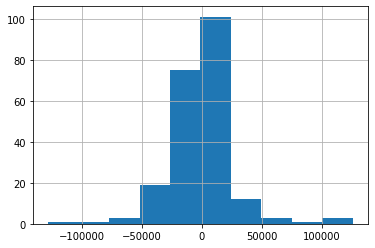

In [76]:
#plot the distribution of the errors
plt.hist(test_y.values.flatten()-y_pred)
plt.grid()

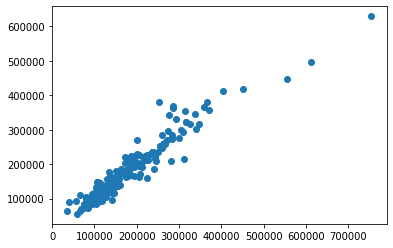

In [77]:
plt.scatter(test_y.values, y_pred)

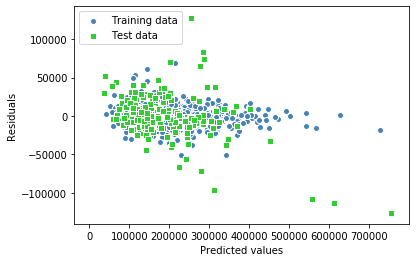

In [78]:
plt.scatter(y_pred_train, (y_pred_train - train_y.values.flatten()),c='steelblue', marker='o', edgecolor='white',label='Training data')
plt.scatter(test_y.values, (y_pred - test_y.values.flatten()),c='limegreen', marker='s', edgecolor='white',label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.show()

it is clear that the model is reproducable, therefore it could be persisted for deployment

In [79]:
joblib.dump(xgboost_rgr, '/home/kolade/repos/house-prediction/persist/xgboost_model.pkl')

['/home/kolade/repos/house-prediction/persist/xgboost_model.pkl']